<a href="https://colab.research.google.com/github/benpkxd/Data-Analysis-Skills/blob/main/Python/Python_MarketingSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rodsaldanha_arketing_campaign_path = kagglehub.dataset_download('rodsaldanha/arketing-campaign')

print('Data source import complete.')


In [ ]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
#Loading the dataset
data = pd.read_csv("/kaggle/input/arketing-campaign/marketing_campaign.csv",sep=";")
data.tail()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,3,0,0,0,0,0,0,3,11,0
2239,9405,1954,PhD,Married,52869.0,1,1,2012-10-15,40,84,...,7,0,0,0,0,0,0,3,11,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# *Data Cleaning*

* Income has missing value
* Dt_customer is not parsed as DateTime
* encode object dtype into numeric


In [ ]:
# remove missing value
data = data.dropna()

In [ ]:
#change to datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
dates = []
for i in data['Dt_Customer']:
    i = i.date()
    dates.append(i)

In [ ]:
data['Dt_Customer'].head()

0   2012-09-04
1   2014-03-08
2   2013-08-21
3   2014-02-10
4   2014-01-19
Name: Dt_Customer, dtype: datetime64[ns]

In [ ]:
#create custmer_for feature
#(number of days the customers started to shop in the store relative to the last recorded date)
days = []
d1 = max(dates)
for i in dates:
    delta = d1-i
    days.append(delta)

data['Customer_for'] = days
data['Customer_for'] = pd.to_numeric(data['Customer_for'], errors="coerce")

#category features enocode to numeric

print(data['Marital_Status'].value_counts(),"\n\n",data['Education'].value_counts())

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [ ]:
# create new features : Age , Spent , Living with , Children , Family_size , Is_Parent
# Age of customer
data['Age'] = 2024-data['Year_Birth']
# Total Spending on  various item
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]
# Living with for adjust status feature
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})
# Childen members in household
data["Children"]=data["Kidhome"]+data["Teenhome"]
# All members in household
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]
# pertaining parenthood?
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)
# adjust and merge education group into 3 big group : undergrad , grad , postgrad
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})
# for clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})
# del unnessisary columns
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [ ]:
data['Education'].value_counts()

Education
Graduate         1116
Postgraduate      846
Undergraduate     254
Name: count, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   int64 

In [ ]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_for,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,55.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,28.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,47.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,54.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,65.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,131.000000,2525.000000,3.000000,5.000000,1.000000


The above stats show some discrepancies in mean Income and Age and max Income and age.

Do note that max-age is 131 years, As I calculated the age that would be today (i.e. 2024) and the data is old.

I must take a look at the broader view of the data. I will plot some of the selected features.

Relative Plot of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

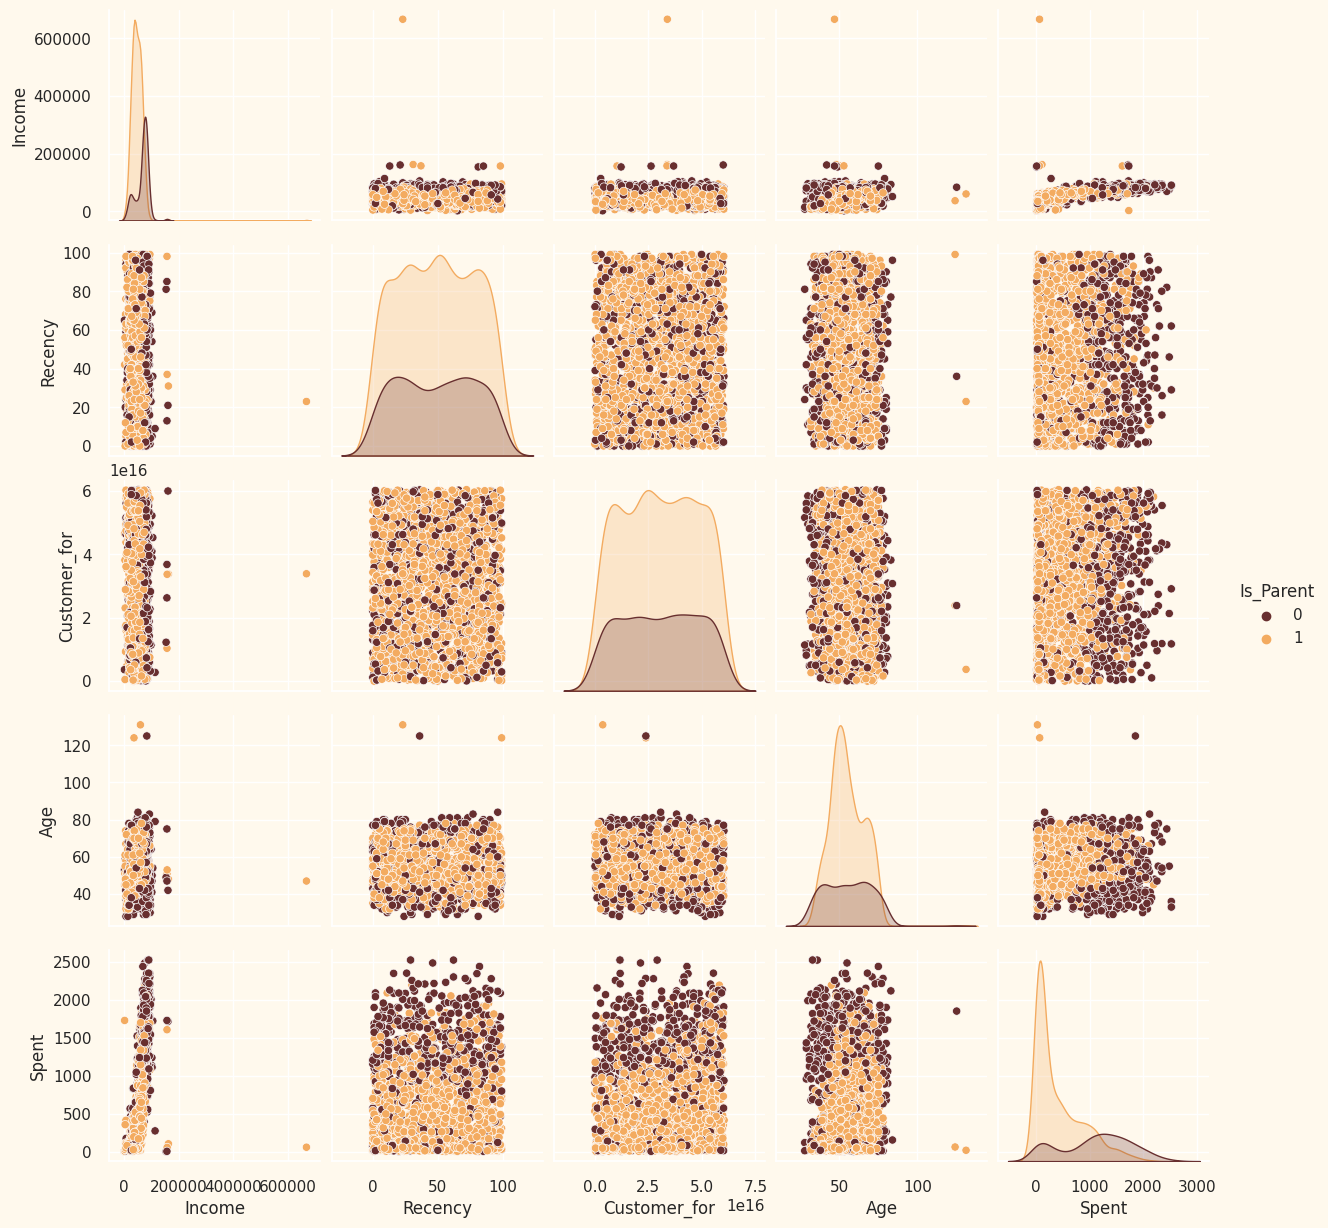

In [ ]:
#Visualization
#Set up color preference
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following feature
To_Plot = ["Income","Recency","Customer_for","Age","Spent","Is_Parent"]
print("Relative Plot of Some Selected Features: A Data Subset")
plt.figure()

sns.pairplot(data[To_Plot],hue = "Is_Parent", palette = (["#682F2F","#F3AB60"]))

plt.show()

Clearly, there are a few outliers in the Income and Age features. I will be deleting the outliers in the data.

In [ ]:
#Del Outliers
data = data[(data['Age']<90)]
data = data[(data['Income']<600000)]
len(data)

2212

<Axes: >

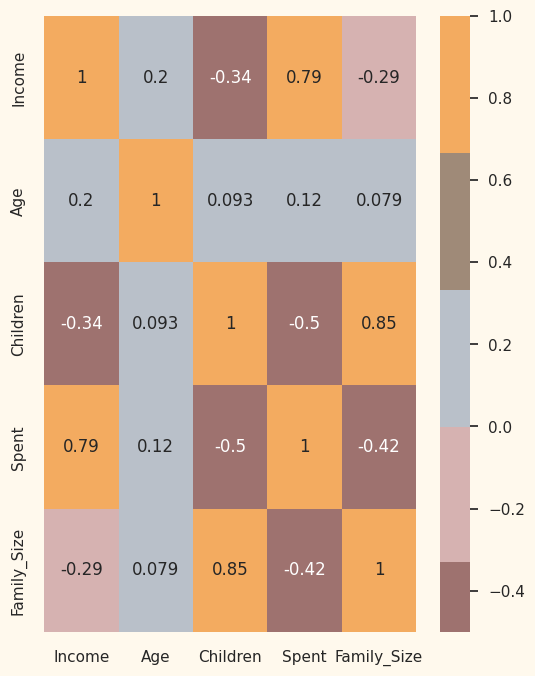

In [ ]:
#correlation matrix
list1 = ["Income","Age","Children","Spent","Family_Size"]
data2 = data[list1]
corrmat= data2.corr()
plt.figure(figsize=(6,8))
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [ ]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
#Label Encoding the object dtypes. (Factorisation encoding)
for i in object_cols:
    data[i]=data[[i]].apply(LabelEncoder().fit_transform)

print("All features are now numerical")

All features are now numerical


In [ ]:
data['Education'].value_counts()

Education
0    1115
1     845
2     252
Name: count, dtype: int64

In [ ]:
#preprocess : copy df and delete unnesessary features
ds = data.copy()

col_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(col_del,axis=1)

In [ ]:
#scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
scaled_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
Education,2212.0,1.124276e-17,1.000226,-0.893586,-0.893586,-0.893586,0.571657,2.036900
Income,2212.0,-1.252765e-16,1.000226,-2.333791,-0.777111,-0.027312,0.767952,5.131311
Kidhome,2212.0,3.533440e-17,1.000226,-0.822754,-0.822754,-0.822754,1.040021,2.902796
Teenhome,2212.0,9.957877e-17,1.000226,-0.929699,-0.929699,-0.929699,0.908097,2.745893
Recency,2212.0,4.015273e-18,1.000226,-1.694030,-0.864630,-0.000672,0.863287,1.727245
Wines,2212.0,4.978939e-17,1.000226,-0.905235,-0.834071,-0.384844,0.592185,3.521791
Fruits,2212.0,7.227492e-18,1.000226,-0.662628,-0.612295,-0.461294,0.167873,4.345543
Meat,2212.0,4.818328e-18,1.000226,-0.744991,-0.673627,-0.441696,0.290897,6.948902
Fish,2212.0,-5.621382e-18,1.000226,-0.687527,-0.632742,-0.468387,0.225554,4.042233
Sweets,2212.0,-5.621382e-18,1.000226,-0.658360,-0.634019,-0.463626,0.144917,5.719175


# *Dimensionality Reduction*
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

*Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.*

Steps in this section:
* Dimensionality reduction with PCA
* Plotting the reduced dataframe


In [ ]:
#Initiating PCR to reduce features
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(['col1','col2','col3']))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,0.000000e+00,2.878602,-5.978123,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,1.927331e-17,1.709469,-4.194757,-1.323932,-0.173716,1.234923,6.168185
col3,2212.0,2.248553e-17,1.231685,-3.625184,-0.853556,-0.051292,0.863841,6.746845


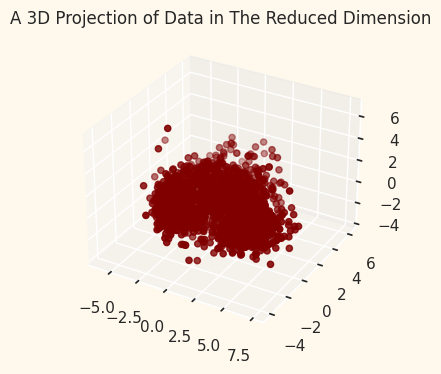

In [ ]:
#3D projection of data in the reduced dimension
x = PCA_ds['col1']
y = PCA_ds['col2']
z = PCA_ds['col3']

#to plot
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(x,y,z, c="maroon", marker = "o")
ax.set_title("A 3D Projection of Data in The Reduced Dimension")
plt.show()

# *Clustering*
Steps involved in the Clustering

* Elbow Method to determine the number of clusters to be formed
* Clustering via Agglomerative Clustering
* Examining the clusters formed via scatter plot

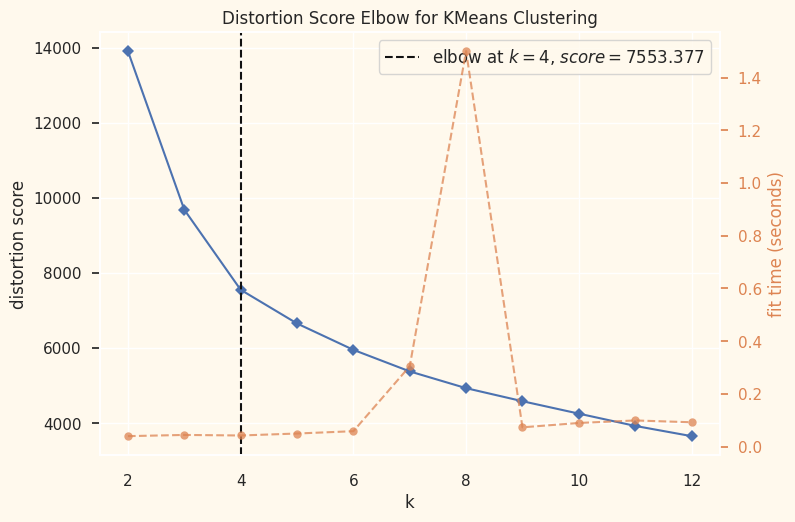

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#Quick examination of elbow method to find numbers of cluster(k) to make
EB=KElbowVisualizer(KMeans(),k=12)
EB.fit(PCA_ds)
EB.show()

In [ ]:
#Initiating the Agglomerative Clustering Model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds['Clusters'] = yhat_AC
# adding the clusters feature to the originnal dataframe
data['Clusters'] = yhat_AC

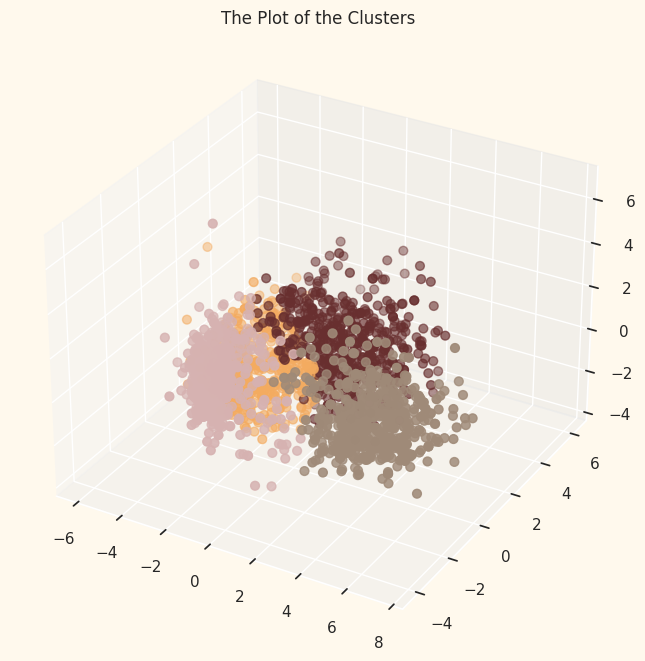

In [ ]:
#plotting the clusters
fig = plt.figure(figsize=(10,8))
ax=plt.subplot(111,projection = "3d",label = 'bla')
ax.scatter(x,y,z, s=40 , c=PCA_ds['Clusters'],marker = 'o',cmap=cmap)
ax.set_title("The Plot of the Clusters")
plt.show()

# *Evaluation Model*

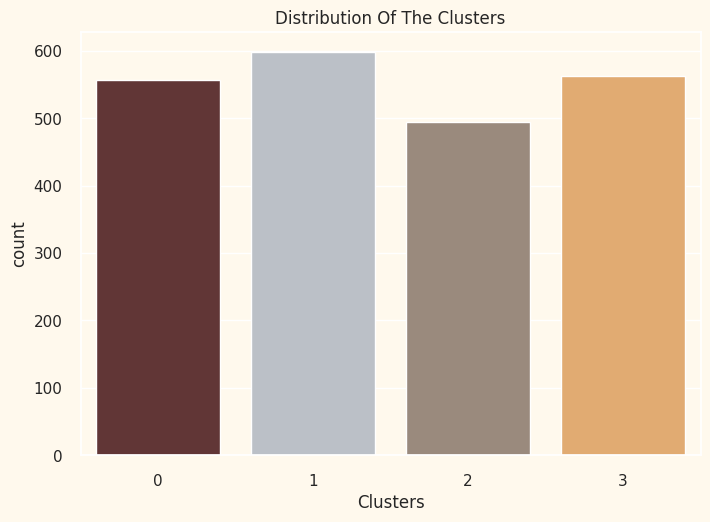

In [ ]:
#Ploting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

the cluster seem to be fairly distributed

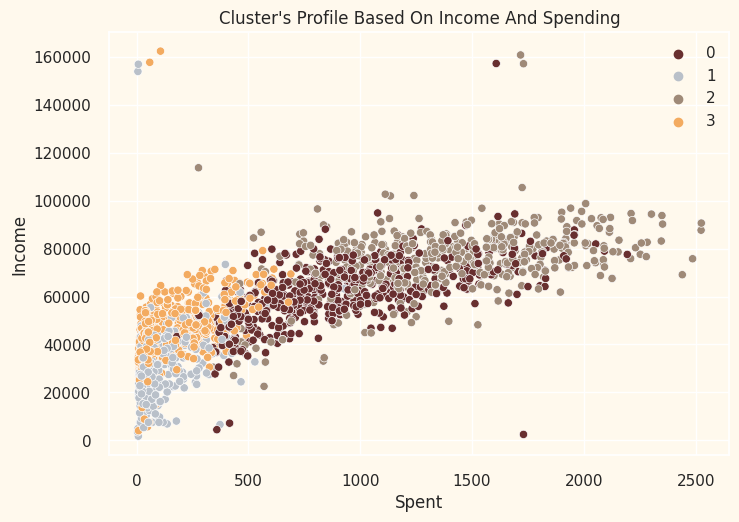

In [ ]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Income vs spending plot shows the clusters pattern

* group 0: high spending & average income
* group 1: high spending & high income
* group 2: low spending & low income
* group 3: high spending & low income

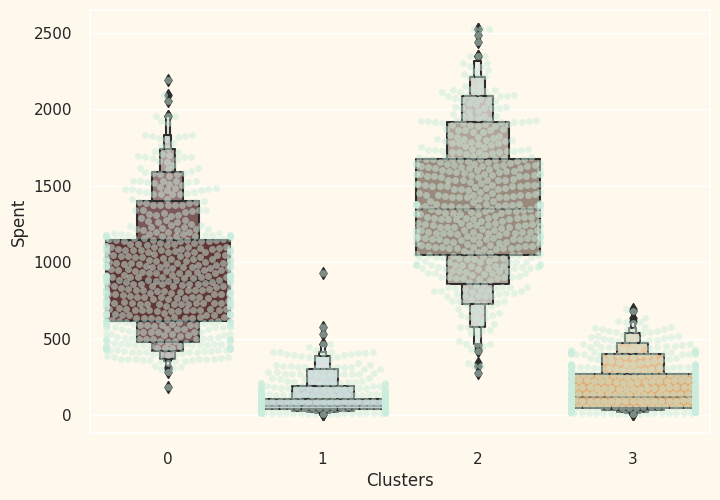

In [ ]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

From the above plot, it can be clearly seen that cluster 1 is our biggest set of customers closely followed by cluster 0. We can explore what each cluster is spending on for the targeted marketing strategies.

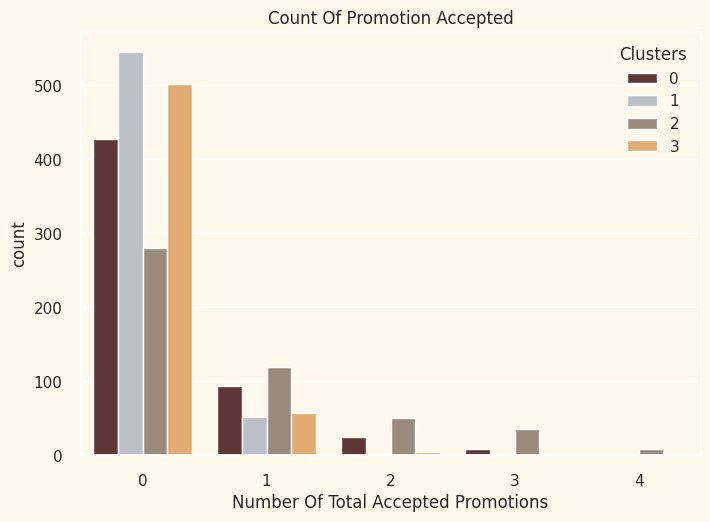

In [ ]:
#Creating a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

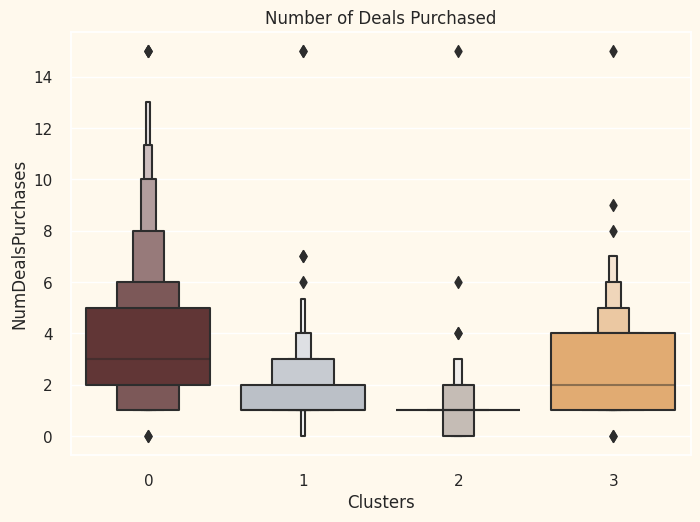

In [ ]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. However, our star customers cluster 1 are not much into the deals. Nothing seems to attract cluster 2 overwhelmingly

# *Profiling*

purchaseing habits study

<Figure size 800x550 with 0 Axes>

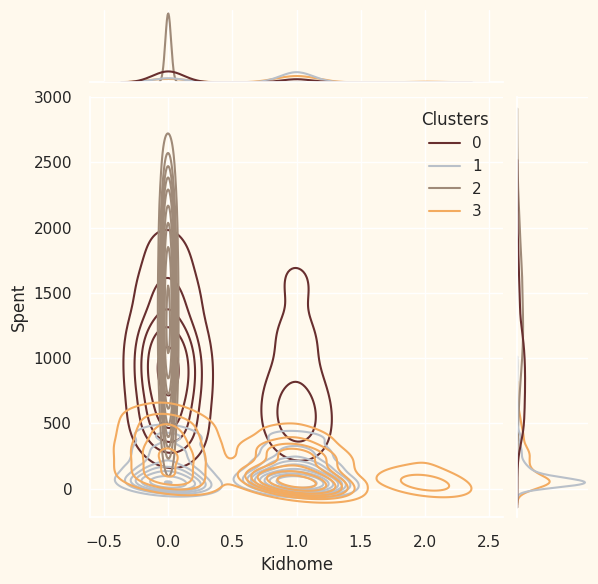

<Figure size 800x550 with 0 Axes>

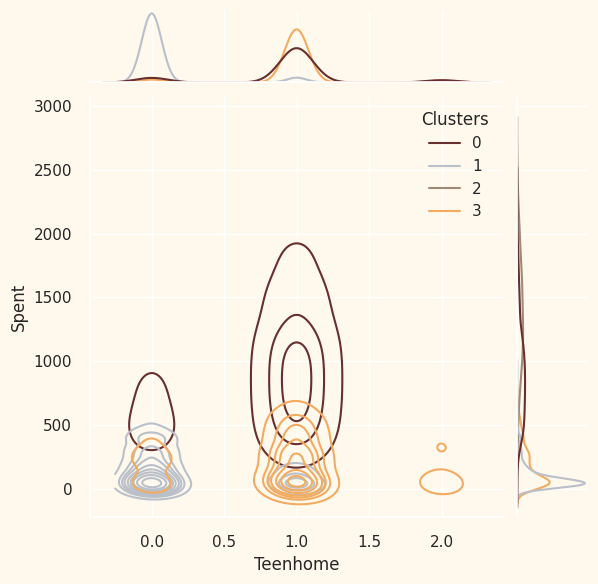

<Figure size 800x550 with 0 Axes>

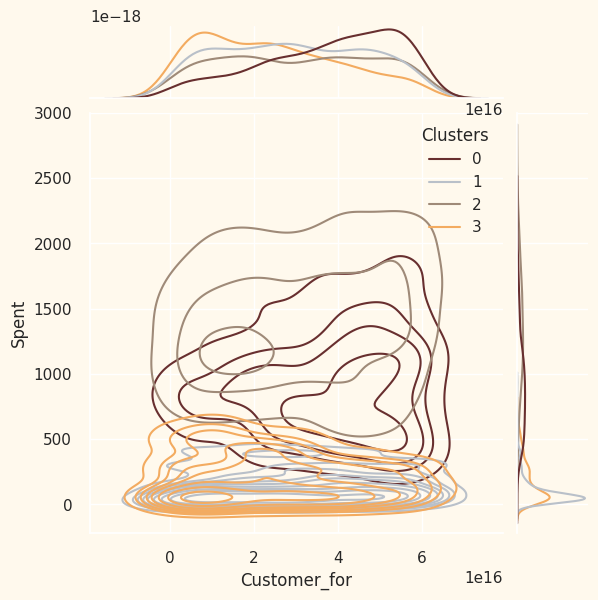

<Figure size 800x550 with 0 Axes>

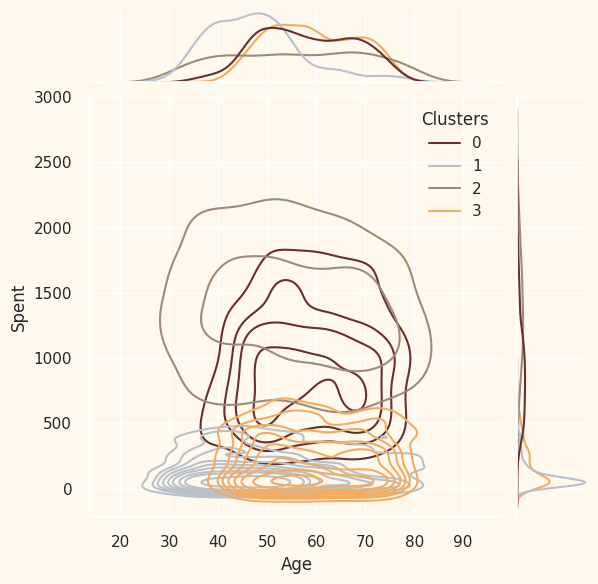

<Figure size 800x550 with 0 Axes>

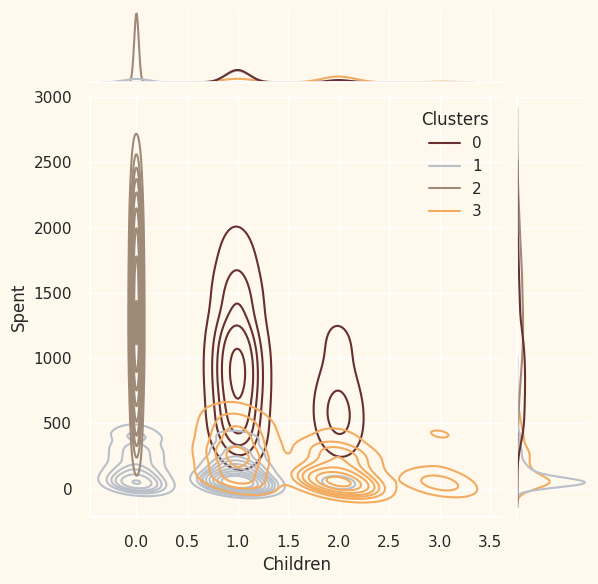

<Figure size 800x550 with 0 Axes>

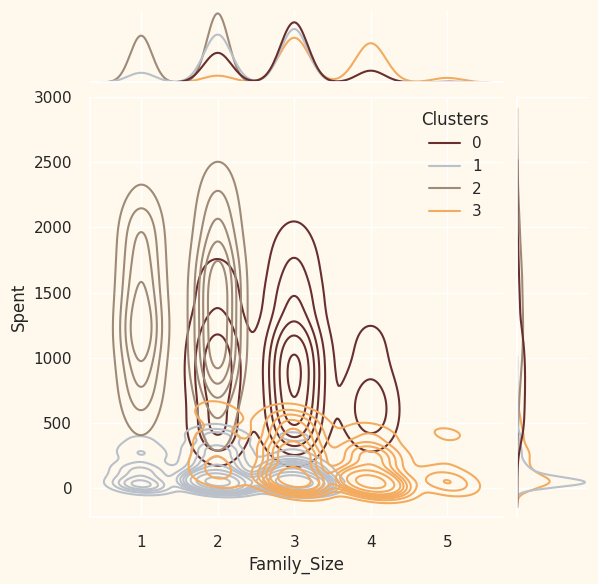

<Figure size 800x550 with 0 Axes>

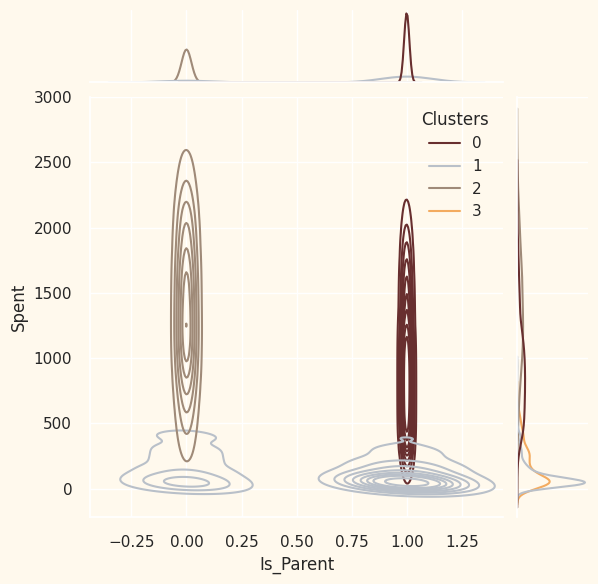

<Figure size 800x550 with 0 Axes>

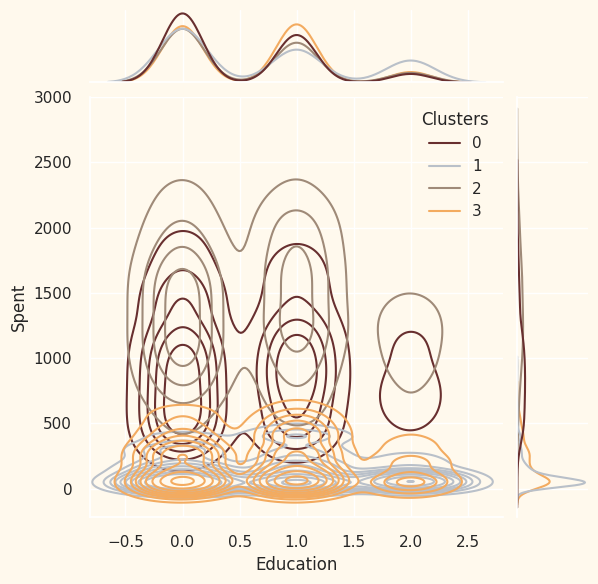

<Figure size 800x550 with 0 Axes>

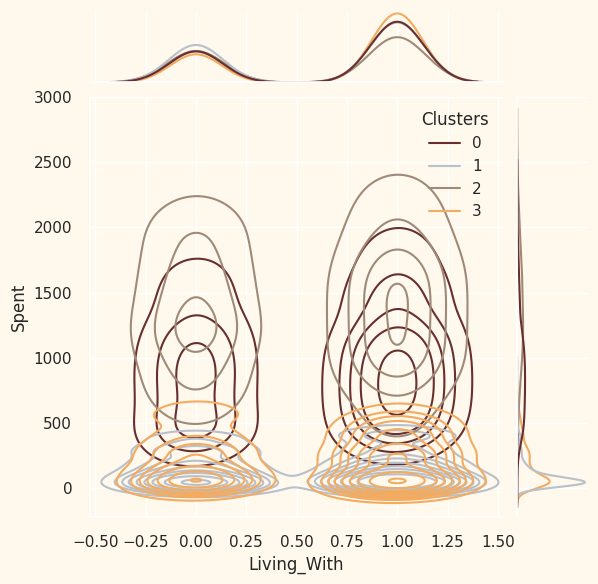

In [ ]:
Personal = [ "Kidhome","Teenhome","Customer_for", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()